# Greta complete Scenic+ workflow
This notebook goes with its corresponding markdown file, with the same name.

`./runi dts/hg38/pbmc10k/cases/all/runs/o_scenicplus.o_scenicplus.o_scenicplus.o_scenicplus.mdl.csv`

to regenerate the DAG : `snakemake dts/hg38/pbmc10k/cases/all/runs/o_scenicplus.o_scenicplus.o_scenicplus.o_scenicplus.mdl.csv --dag | dot -Tsvg > dag.svg` 

In [62]:
import numpy as np
import pandas as pd
import os
import pyarrow.feather as feather
import pyarrow as pa

Here are the jobs triggered by the rules : 
```bash
job                      count
---------------------  -------
annotate_pbmc10k             1
callpeaks_pbmc10k            1
cre_blacklist                1
dwn_image                    2
extract_case                 1
gen_genome_scenicplus        1
gen_gid_ensmbl               1
gen_motif_scenicplus         1
mdl_o_scenicplus             1
prcannot_pbmc10k             1
total                       11
``` 

## 1. Inputs 

In [20]:
dir = "/globalscratch/vangysel/greta"

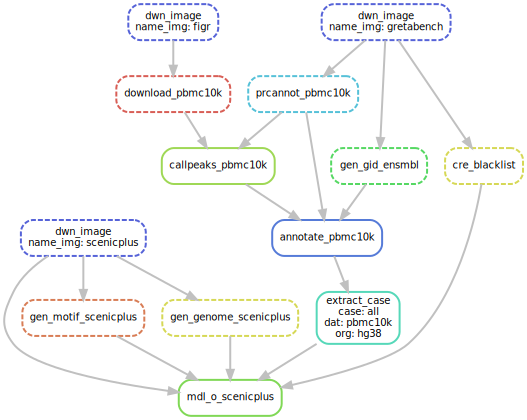

In [11]:
from IPython.display import SVG, display
display(SVG(filename=f"{dir}/notes_scenic+/dag.svg"))

We will go through each layer of the DAG (top layer is the `dwn_image` and last layer is `mdl_o_scenicplus`)

### Layer 1 
Download `figr.sif` & `gretabench.sif` the images used to run the further steps.


### Layer 2 

-  `download_pbmc10k` : download the pbmc10k dataset (get ATAC files, RNA are downloaded sperately and cached)
    - `dts/hg38/pbmc10k/smpl.frags.tsv.gz`
    - `dts/hg38/pbmc10k/smpl.frags.tsv.gz.tbi`
<br><br>
      
- `prcannot_pbmc10k` : cell annotation (metadata)

In [21]:
frags = pd.read_csv(
    f"{dir}/dts/hg38/pbmc10k/smpl.frags.tsv.gz",
    sep="\t",
    nrows=100000,   # do not load the entire file
    header=None,
    names=["chr", "start", "end", "barcode", "count"]
)

In [22]:
frags.head(3)

,chr,start,end,barcode,count
0,chr1,10066,10478,smpl_TCAAGAACAGTAATAG,1
1,chr1,10072,10191,smpl_AACCCGCAGGTAGCTT,1
2,chr1,10073,10340,smpl_CGCATATAGGTTACGT,2


In [25]:
pbmc_annot = pd.read_csv(f"{dir}/dts/hg38/pbmc10k/annot.csv")

In [27]:
pbmc_annot.head(3)

,Unnamed: 0,batch,celltype
0,smpl_AAACAGCCAATCCCTT,smpl,CD4 TCM
1,smpl_AAACAGCCAATGCGCT,smpl,CD4 Naive
2,smpl_AAACAGCCACCAACCG,smpl,CD8 Naive


### Layer 3
- `gen_gid_ensmbl` : gene id symbol mapping

In [44]:
ens_human = pd.read_csv(f"{dir}/dbs/hg38/gen/gid/ensembl.csv")
ens_mouse = pd.read_csv(f"{dir}/dbs/mm10/gen/gid/ensembl.csv")

In [45]:
ens_human.head(3)

,id,symbol
0,ENSG00000210049,MT-TF
1,ENSG00000211459,MT-RNR1
2,ENSG00000210077,MT-TV


- `cre_blacklist` : regions to ignore

In [42]:
blacklist = pd.read_csv(
    f"{dir}/dbs/hg38/cre/blacklist/blacklist.bed.gz",
    sep="\t",
    header=None,
    names=["start", "end", "reason"]
)

In [43]:
blacklist.head(3)

,start,end,reason
chr10,0,45700,Low Mappability
chr10,38481300,38596500,High Signal Region
chr10,38782600,38967900,High Signal Region


- `callpeaks_pbmc10k`

### Layer 4 
- `annotate_pbmc10k`

In [ ]:
# read .h5mu multiomcs 

In [ ]:
dbs/hg38/cre/blacklist/blacklist.bed.gz

### Layer 5

The PBMC10k dataset is now ready (`.h5mu` file), we can run `mdl_o_scenicplus`.  <br><br>
It needs the following inputs : <br>
2) `blist` : cre blacklist (already download in Layer 3 : `cre_blacklist`)

#### 5.1 From `gen_motif_scenicplus`


3) `rnk`: regions_vs_motifs.rankings

In [72]:
path = f"{dir}/dbs/hg38/gen/motif/scenicplus/human_motif_SCREEN.regions_vs_motifs.rankings.feather"

source = pa.memory_map(path, 'r')
reader = pa.ipc.open_file(source)
schema = reader.schema

In [80]:
print("First 5 cols:", schema.names[:5])
print("Last 5 cols:", schema.names[-5:])
print("Motifs col type:", schema.field('motifs').type)
print("Metadata:", schema.metadata)

First 5 cols: ['chr10:100000176-100000504', 'chr10:100001759-100001930', 'chr10:100004841-100005148', 'chr10:100005876-100006219', 'chr10:100006302-100006644']
Last 5 cols: ['chrY:9924284-9924623', 'chrY:9954840-9955041', 'chrY:9959132-9959359', 'chrY:9997981-9998328', 'motifs']
Motifs col type: string
Metadata: None


4) `man` : motif annotations


In [58]:
man_sample = pd.read_csv(
    f"{dir}/dbs/hg38/gen/motif/scenicplus/motifs-v10nr_clust/nr.hgnc-m0.001-o0.0.tbl",
    sep="\t",
    nrows=10000 
)

In [60]:
man_sample.head(3)

,#motif_id,motif_name,motif_description,source_name,source_version,gene_name,motif_similarity_qvalue,similar_motif_id,similar_motif_description,orthologous_identity,orthologous_gene_name,orthologous_species,description
0,metacluster_196.3,EcR_usp,EcR/usp,bergman,1.1,HNF4A,0.0,NaN,NaN,0.270042,FBgn0003964,D. melanogaster,gene is orthologous to FBgn0003964 in D. melan...
1,metacluster_196.3,EcR_usp,EcR/usp,bergman,1.1,HNF4G,0.0,NaN,NaN,0.276923,FBgn0003964,D. melanogaster,gene is orthologous to FBgn0003964 in D. melan...
2,metacluster_196.3,EcR_usp,EcR/usp,bergman,1.1,NR1D1,0.0,NaN,NaN,0.157980,FBgn0000546,D. melanogaster,gene is orthologous to FBgn0000546 in D. melan...


5) `scr`: regions_vs_motifs.scores


In [86]:
path = f"{dir}/dbs/hg38/gen/motif/scenicplus/human_motif_SCREEN.regions_vs_motifs.scores.feather"

source = pa.memory_map(path, 'r')
reader = pa.ipc.open_file(source)
batch = reader.get_batch(0)

# Check dtype first
region_col = reader.schema.names[0]
print(f"Dtype: {reader.schema.field(region_col).type}")

Dtype: float


In [93]:
print("First 5 cols:", schema.names[:5])
print("Last 5 cols:", schema.names[-5:])
print("Motifs col type:", schema.field('motifs').type)
print("Metadata:", schema.metadata)

First 5 cols: ['chr10:100000176-100000504', 'chr10:100001759-100001930', 'chr10:100004841-100005148', 'chr10:100005876-100006219', 'chr10:100006302-100006644']
Last 5 cols: ['chrY:9924284-9924623', 'chrY:9954840-9955041', 'chrY:9959132-9959359', 'chrY:9997981-9998328', 'motifs']
Motifs col type: string
Metadata: None


#### 5.2 From `gen_genome_scenicplus`

6) `ann`: annotation.tsv


In [95]:
ann = pd.read_csv(f"{dir}/dbs/hg38/gen/genome/scenicplus/annotation.tsv", sep="\t")
ann.head(3)

,Chromosome,Start,End,Strand,Gene,Transcription_Start_Site,Transcript_type
0,chrM,3307,4262,+,MT-ND1,3307,protein_coding
1,chrM,4470,5511,+,MT-ND2,4470,protein_coding
2,chrM,5904,7445,+,MT-CO1,5904,protein_coding


7) `csz`: chromsizes.tsv

In [ ]:
csz = pd.read_csv(f"{dir}/dbs/hg38/gen/genome/scenicplus/chromsizes.tsv", sep="\t")
csz.head(3)

In [101]:
tss = pd.read_csv(f"{dir}/dbs/hg38/gen/genome/scenicplus/tss.tsv", sep="\t")
tss.head(3)

,# Chromosome,Start,End,Gene,Score,Strand,Transcript_type,Ensembl_gene_id
0,chrM,3306,3307,MT-ND1,.,+,protein_coding,ENSG00000198888
1,chrM,4469,4470,MT-ND2,.,+,protein_coding,ENSG00000198763
2,chrM,5903,5904,MT-CO1,.,+,protein_coding,ENSG00000198804


#### 5.3 `extract_case`
1) `mdata` : mdata.h5mu (multiomics data) will be extracted from rule `annotate_pbmc10k` in Layer 4

### Layer 6 
We now have all the inputs ready, we can run the main script `workflow/scripts/mth/scenicplus/o_mdl.sh`

## 3. Script execution